**Table of contents**<a id='toc0_'></a>    
- 1. [Clustering approach to measuring synchronization    ](#toc1_)    
- 2. [Load data    ](#toc2_)    
  - 2.1. [Load earthquakes    ](#toc2_1_)    
  - 2.2. [Load tremor    ](#toc2_2_)    
  - 2.3. [Select nearby earthquakes, and project events along the fault    ](#toc2_3_)    
- 3. [Explicit detection of clusters ](#toc3_)    
- 4. [Measure proportion of events in, and recurrence of *system-spanning clusters* ](#toc4_)    
  - 4.1. [For just one zone ](#toc4_1_)    
  - 4.2. [For the whole region ](#toc4_2_)    
- 5. [For one zone, look at clusters in a more continuous way](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Clustering approach to measuring synchronization     [&#128285;](#toc0_)

Here, we demonstrate (on Cascadia tremor) a clustering approach to measuring the synchronization of a given region. The approach consists in explicitly detecting clusters, selecting clusters that are characteristic of the synchronous behavior (largest clusters for instance), and measuring the proportion of events in them, their recurrence intervals, and its regularity.

For now, the problems I have with it are:
- Cluster detection is parameter heavy, and needs to be adapted to different datasets, and even sometimes different zones.
- Clusters selection introduces bias, and is hard to parametrize so that we measure the observed synchronization similarly as what we see by eye. For instance, we only detect large clusters in a not syncronized region, which appear periodic, but not the small ones that are very frequent, and are more characteristic of the not synchronized behavior.

In [10]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load data     [&#128285;](#toc0_)

In [2]:
# Constants for everyone
day0 = np.datetime64('2009-08-01')

## 2.1. <a id='toc2_1_'></a>Load earthquakes     [&#128285;](#toc0_)

In [4]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2009-08-01"
t1 = "2024-04-04"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 39
maxlat = 54
minlon = -128
maxlon = -121
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq['time'])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2009-08-01&endtime=2024-04-04&minlatitude=39&maxlatitude=54&minlongitude=-128&maxlongitude=-121&minmagnitude=1.6&eventtype=earthquake


## 2.2. <a id='toc2_2_'></a>Load tremor     [&#128285;](#toc0_)

In [5]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/tremor_all_cascadia_09_24.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)
tremor['date'] = pd.to_datetime(tremor['starttime'])

# Find str in duration of tremor and convert them to float by stripping the space and converting to float (still misses some ' None ', don't know what to do with them...)
tremor.duration = tremor.duration.apply(lambda x: float(x.strip()) if x is str else x)

# Sort tremor by date
tremor = tremor.sort_values('date')

# Compute the day in the sequence for tremor
day0 = np.datetime64('2009-08-01')
tremor['day'] = (tremor.date - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_28889/3805188776.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


## 2.3. <a id='toc2_3_'></a>Select nearby earthquakes, and project events along the fault     [&#128285;](#toc0_)

In [6]:
# Project onto a straight line
# --> Define center line of tremor
lat_center = np.arange(39, 52, 0.2)
dlat = 0.4
center_line = np.zeros((len(lat_center), 2))

for ii, lat in enumerate(lat_center):
    lat_min = lat - dlat
    lat_max = lat + dlat
    tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
    center_line[ii, 1] = (lat_min + lat_max) / 2
    center_line[ii, 0] = tremor_bin.lon.median()

# --> Fit it with a straight line to find the transect points
p = np.polyfit(center_line[~np.isnan(center_line[:, 0]), 1], center_line[~np.isnan(center_line[:, 0]), 0], 1)
N_point = p[0] * 52 + p[1]
S_point = p[0] * 39 + p[1]
transect_line = {'N':{'lat': 52, 'lon': N_point}, 'S': {'lat': 39, 'lon': S_point}}

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1])
# plt.plot([transect_line['N']['lon'], transect_line['S']['lon']], [transect_line['N']['lat'], transect_line['S']['lat']])
# plt.show()

# --> Project earthquakes onto the line
t = transect(eq.lon.values, eq.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# --> Project tremor onto the line
t = transect(tremor.lon.values, tremor.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
tremor['xf'] = t[0]
tremor['yf'] = t[1]


In [8]:
# Find which points are left or right of the line drawn on the map
east_line = np.loadtxt('data/cascadia/tremor_region_east_line.txt')
west_line = np.loadtxt('data/cascadia/tremor_region_west_line.txt')

# For each earthquake
def which_side(M, A, B):
    return np.sign((B[0] - A[0]) * (M[1] - A[1]) - (B[1] - A[1]) * (M[0] - A[0]))

# For each earthquake, find the points of the line it's longitude is between, and then using those points, find if the earthquake is left or right of the line
eq['east'] = np.zeros(len(eq))
eq['west'] = np.zeros(len(eq))
for ii, row in eq.iterrows():
    M = (row['lon'], row['lat'])
    for jj in range(len(east_line)-1):
        A = (east_line[jj][1], east_line[jj][0])
        B = (east_line[jj+1][1], east_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'east'] = side
    for jj in range(len(west_line)-1):
        A = (west_line[jj][1], west_line[jj][0])
        B = (west_line[jj+1][1], west_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'west'] = side

eq_near = eq[(eq.east == -1) & (eq.west == 1)]

# %matplotlib widget
# # Map of data
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# # Add coastlines
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# # Add states
# ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# # Add earthquakes
# ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
# ax.scatter(eq_near.lon, eq_near.lat, s=eq_near.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# # Add tremor
# ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# # Show east and west lines
# ax.plot(east_line[:, 1], east_line[:, 0], 'r--', transform=ccrs.PlateCarree())
# ax.plot(west_line[:, 1], west_line[:, 0], 'r--', transform=ccrs.PlateCarree())

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# # Set extent for Cascadia subduction zone
# extent = [-128, -121, 39, 52]
# ax.set_extent(extent)

# plt.show()

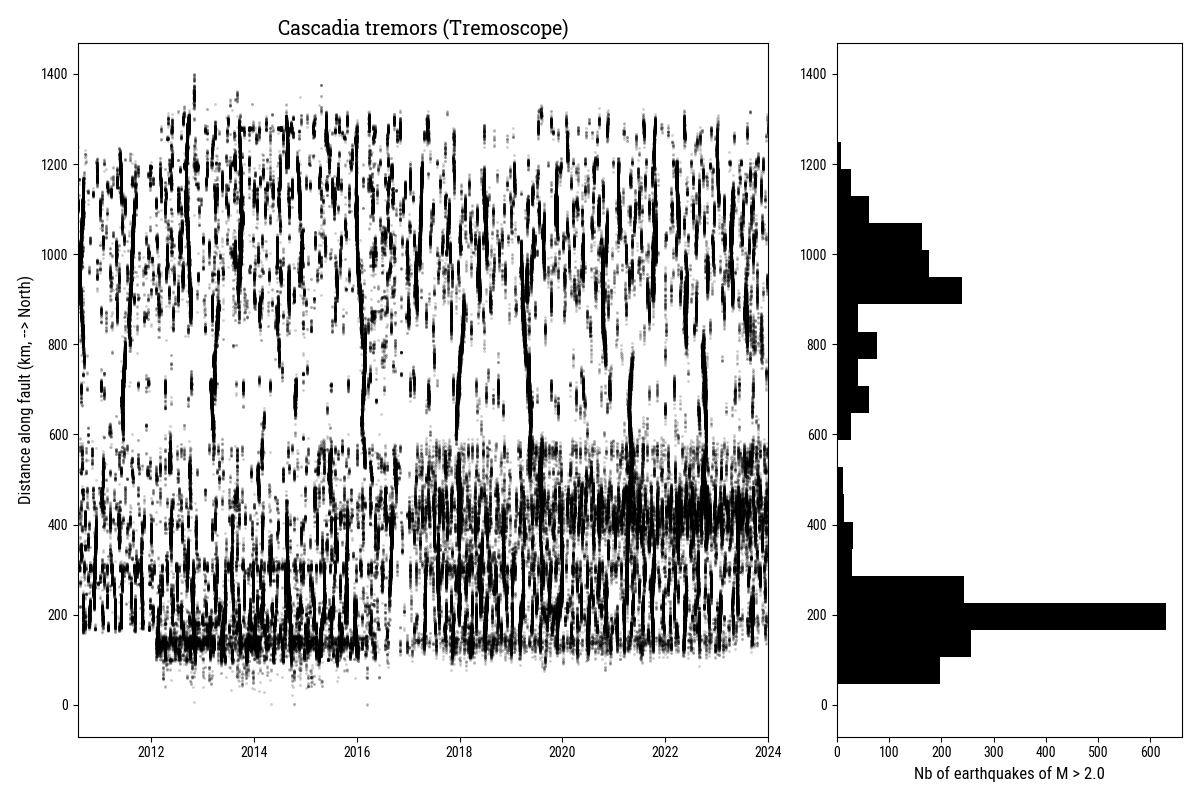

In [9]:
# Plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (Tremoscope)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(tremor.date, tremor.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax.set_xlim(np.datetime64('2010-08-01'), np.datetime64('2024-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[(eq_near.mag > min_m) & (eq_near.depth < 65) & (eq_near.depth > 10)], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Explicit detection of clusters  [&#128285;](#toc0_)

Good parameters for different regions:
- Cascadia (Wech tremor): `t0 = 7 days`, `x0 = 50 km`, `eps=.5 km`, `min_samples=20`
- Nankai (WTD tremor): `t0 = 7 days`, `x0 = 20 km`, `eps=.5 km`, `min_samples=20`
- Parkfield (Shelly LFEs): `x0 = 1 day`, `t0 = 20 km`, `eps=.5 km`, `min_samples=400` (for South)

Detected 1715 clusters
Detected 1715 clusters
Min, median, max number of LFEs in a cluster: 18, 72.0, 15488


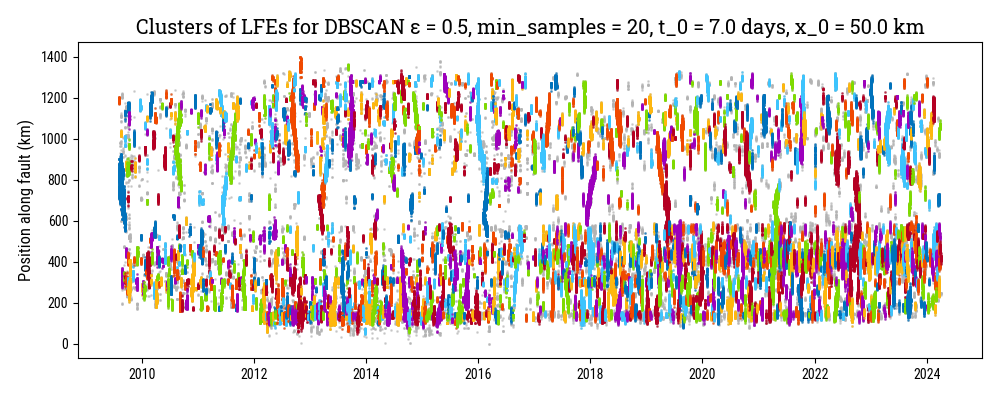

In [11]:
# Parameters for cluster detection
ev_x = tremor['xf'].values
ev_t = tremor['day'].values

t0 = 7. # scaling factor for time (in days)
x0 = 50. # scaling factor for position (in km)

X = np.column_stack([ev_x / x0, ev_t / t0])

# Parameters for the clustering model
dbs = DBSCAN(eps=.5, min_samples=20)

# Fit the model
clusters_fit = dbs.fit(X)

print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))

# Stats on the clusters
print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))
print('Min, median, max number of events in a cluster: {:}, {:}, {:}'.format(np.min(np.bincount(clusters_fit.labels_+1)[1:]), np.median(np.bincount(clusters_fit.labels_+1)[1:]), np.max(np.bincount(clusters_fit.labels_+1)[1:])))

# Show clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Clusters of events for DBSCAN ε = {:}, min_samples = {:}, t_0 = {:} days, x_0 = {:} km'.format(dbs.eps, dbs.min_samples, t0, x0), fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')
# ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2019-01-01'))

ax.plot(tremor.date, tremor.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in np.unique(clusters_fit.labels_):
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
# Make clusters dataframe
tremor['cluster_id'] = clusters_fit.labels_

# Group LFEs by cluster ID
cluster_groups = tremor.groupby('cluster_id')

# Initialize an empty dataframe to store cluster information
clusters_df = pd.DataFrame(columns=['id',
                                    'n_ev',
                                    't_first',
                                    't_last',
                                    'x_min',
                                    'x_max',
                                    'z_min',
                                    'z_max',
                                    't_centroid',
                                    'x_centroid',
                                    'z_centroid',
                                    't_first80',
                                    't_last80',
                                    'x_min90',
                                    'x_max90',
                                    'duration80'])

# Loop over the cluster groups and compute statistics for each cluster
for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue
    n_ev = len(cluster_data)
    t_first = cluster_data['date'].min()
    t_last = cluster_data['date'].max()
    x_min = cluster_data['xf'].min()
    x_max = cluster_data['xf'].max()
    z_min = cluster_data['depth'].min()
    z_max = cluster_data['depth'].max()
    t_centroid = np.percentile(cluster_data['date'], 50)
    x_centroid = np.median(cluster_data['xf'])
    z_centroid = np.median(cluster_data['depth'])
    t_first80 = np.percentile(cluster_data['date'], 10)
    t_last80 = np.percentile(cluster_data['date'], 90)
    x_min90 = np.percentile(cluster_data['xf'], 5)
    x_max90 = np.percentile(cluster_data['xf'], 95)
    duration80 = (t_last80 - t_first80) / np.timedelta64(1, 's')  # in seconds
    span90 = x_max90 - x_min90

    # Add cluster information to the dataframe
    clusters_df.loc[len(clusters_df)] = [cluster_id, n_ev, t_first, t_last, x_min, x_max, z_min, z_max, t_centroid, x_centroid, z_centroid, t_first80, t_last80, x_min90, x_max90, duration80]

# 4. <a id='toc4_'></a>Measure proportion of events in, and recurrence of *system-spanning clusters*  [&#128285;](#toc0_)

## 4.1. <a id='toc4_1_'></a>For just one zone  [&#128285;](#toc0_)

In [13]:
# Select a bin and detect "system-spanning clusters"
bin_xmin = 400
bin_xmax = 600

q_min_span = .66  # proportion of bin to span for cluster to be considere

fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

selected_clusters = clusters_df[bin_spanning_clusters]

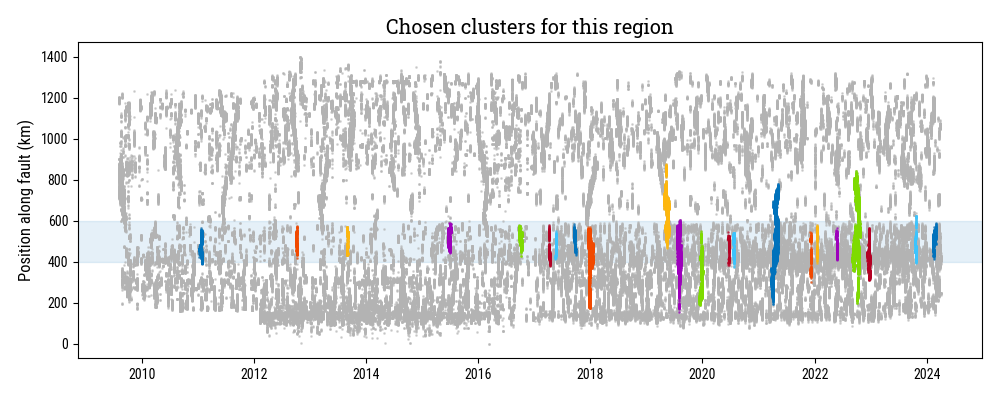

In [14]:
# Show
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Chosen clusters for this region', fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')

ax.axhspan(bin_xmin, bin_xmax, color='C0', alpha=.1)

ax.plot(tremor.date, tremor.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in selected_clusters.id:
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
# Compute different measures of synchronization
# --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

print('Proportion of events in bin-spanning clusters: {:.2f}\n'.format(n_ev_in_clusters / n_ev_in_bin))

# --> Periodicity detection and its COV
selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
mean_dT = np.mean(selected_clusters_dT)
std_dT = np.std(selected_clusters_dT)
cov_dT = std_dT / mean_dT

print('Mean period: {:.2f} days ({:.2f} months)'.format(mean_dT, mean_dT / 30.5))
print('Standard deviation of period: {:.2f} days ({:.2f} months)'.format(std_dT, mean_dT / 30.5))
print('Coefficient of variation of period (periodicity): {:.2f}'.format(cov_dT))

Proportion of events in bin-spanning clusters: 0.38

Mean period: 227.27 days (7.45 months)
Standard deviation of period: 183.94 days (7.45 months)
Coefficient of variation of period (periodicity): 0.81


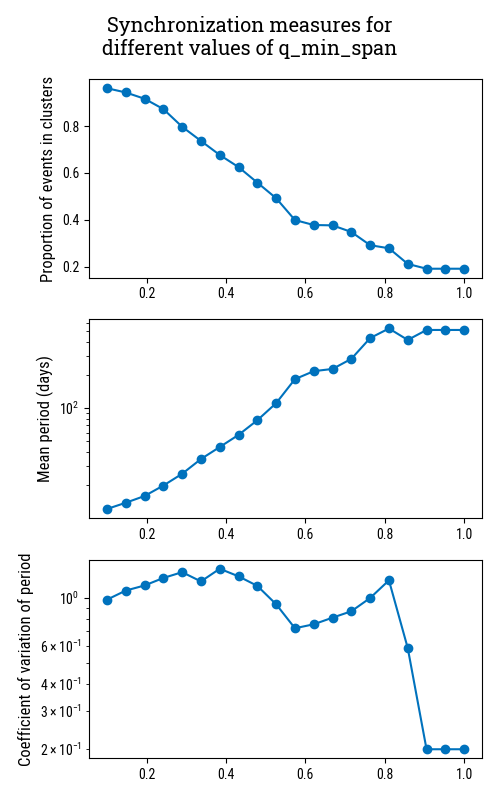

In [16]:
# For one bin, try different values of q_min_span
q_min_spans = np.linspace(.1, 1., 20)

# Initialize empty arrays to store the results
prop_in_clusters = np.zeros_like(q_min_spans)
mean_periods = np.zeros_like(q_min_spans)
std_periods = np.zeros_like(q_min_spans)
cov_periods = np.zeros_like(q_min_spans)

for ii, q_min_span in enumerate(q_min_spans):
    # Define bin and select clusters
    fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
    xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
    xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

    cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

    size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

    bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

    selected_clusters = clusters_df[bin_spanning_clusters]

    # Compute different measures of synchronization
    # --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
    n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
    n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

    prop_in_clusters[ii] = n_ev_in_clusters / n_ev_in_bin

    # --> Periodicity detection and its COV
    selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
    mean_dT = np.mean(selected_clusters_dT)
    std_dT = np.std(selected_clusters_dT)
    cov_dT = std_dT / mean_dT

    mean_periods[ii] = mean_dT
    std_periods[ii] = std_dT
    cov_periods[ii] = cov_dT

# Plot
fig, ax = plt.subplots(3, 1, figsize=(5, 8))
fig.suptitle('Synchronization measures for\ndifferent values of q_min_span', fontname='Roboto Slab')

ax[0].plot(q_min_spans, prop_in_clusters, 'o-')
ax[0].set_ylabel('Proportion of events in clusters')

ax[1].plot(q_min_spans, mean_periods, 'o-')
ax[1].set_ylabel('Mean period (days)')
ax[1].set_yscale('log')

ax[2].plot(q_min_spans, cov_periods, 'o-')
ax[2].set_ylabel('Coefficient of variation of period')
ax[2].set_yscale('log')

plt.tight_layout()
plt.show()

## 4.2. <a id='toc4_2_'></a>For the whole region  [&#128285;](#toc0_)

In [17]:
# Parameters
q_min_span = .66  # proportion of bin to span for cluster to be considered

xmin = 200  # in km, the northern limit of the binning
xmax = 1200  # in km, the southern limit of the binning

wbin = 100  # in km, the width of the bin
ovlp = .5  # proportion of overlap between bins


In [18]:
# Compute measure in each bin
bin_xmins = np.arange(xmin, xmax - wbin*ovlp , wbin * (1 - ovlp))
bin_xmaxs = bin_xmins + wbin

# Initialize empty arrays to store the results
prop_in_clusters = np.zeros_like(bin_xmins)
mean_periods = np.zeros_like(bin_xmins)
std_periods = np.zeros_like(bin_xmins)
cov_periods = np.zeros_like(bin_xmins)

for ii, (bin_xmin, bin_xmax) in enumerate(zip(bin_xmins, bin_xmaxs)):
    # Select clusters in bin
    fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
    xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
    xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

    cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

    size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

    bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

    selected_clusters = clusters_df[bin_spanning_clusters]

    # Compute different measures of synchronization
    # --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
    n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
    n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

    prop_in_clusters[ii] = n_ev_in_clusters / n_ev_in_bin

    # --> Periodicity detection and its COV
    selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
    mean_dT = np.mean(selected_clusters_dT)
    std_dT = np.std(selected_clusters_dT)
    cov_dT = std_dT / mean_dT

    mean_periods[ii] = mean_dT
    std_periods[ii] = std_dT
    cov_periods[ii] = cov_dT

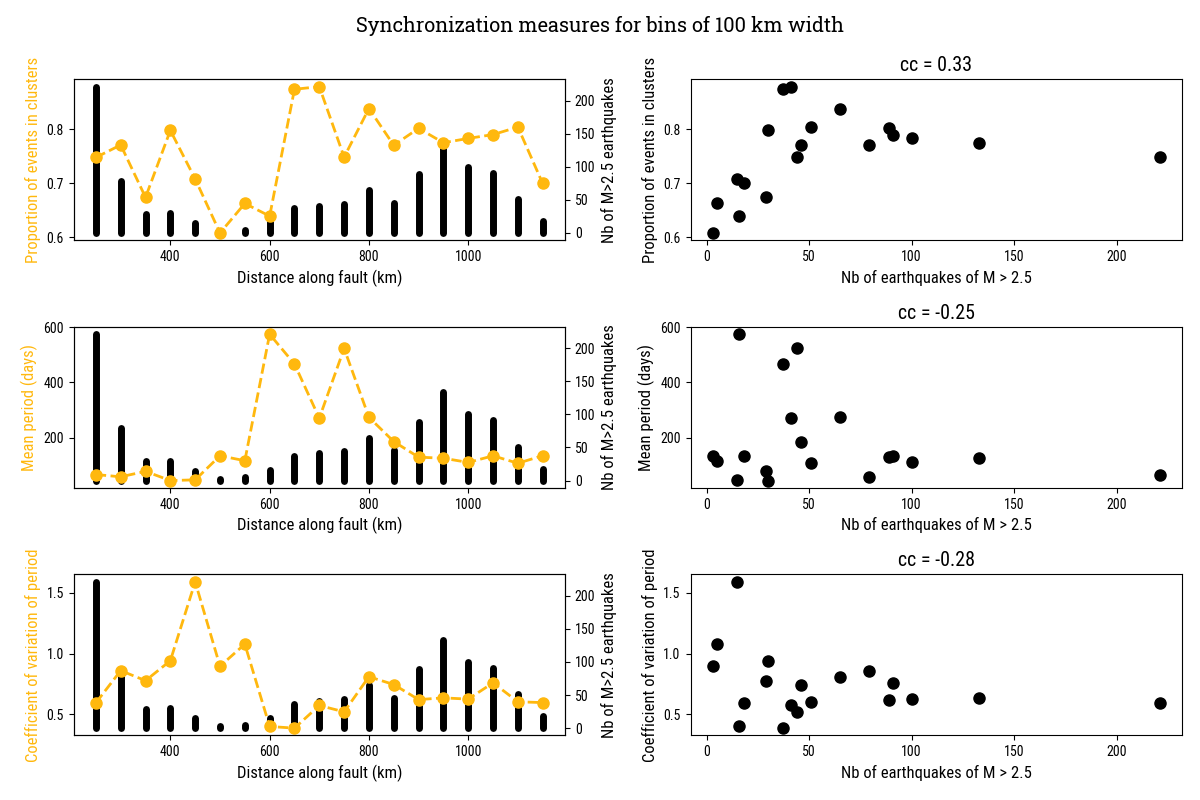

In [19]:
# Plot
mag_min = 2.5
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Synchronization measures for bins of {:} km width'.format(wbin), fontname='Roboto Slab')

axes[0, 0].plot(bin_xmins + wbin/2, prop_in_clusters, 'o--', c='C2', ms=8, lw=2)
axes[0, 0].set_ylabel('Proportion of events in clusters', c='C2')
axes_1 = []
axes_1.append(axes[0, 0])

axes[1, 0].plot(bin_xmins + wbin/2, mean_periods, 'o--', c='C2', ms=8, lw=2)
axes[1, 0].set_ylabel('Mean period (days)', c='C2')
axes_1.append(axes[1, 0])

axes[2, 0].plot(bin_xmins + wbin/2, cov_periods, 'o--', c='C2', ms=8, lw=2)
axes[2, 0].set_ylabel('Coefficient of variation of period', c='C2')
axes_1.append(axes[2, 0])

for ax in axes_1:
    ax_eq = ax.twinx()
    # count earthquakes in each bin
    eq_in_bin = np.array([len(eq_near[(eq_near.xf >= bin_xmin) & (eq_near.xf <= bin_xmax) & (eq_near.mag > mag_min)]) for bin_xmin, bin_xmax in zip(bin_xmins, bin_xmaxs)])
    X, Y = [], []
    for x,y in zip(bin_xmins + wbin/2, eq_in_bin):
        X.extend([x, x, None]), Y.extend([0, y, None])
    ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
    ax.set_zorder(ax_eq.get_zorder()+1)
    ax.patch.set_visible(False)
    ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

    ax.set_xlabel('Distance along fault (km)')


axes[0, 1].plot(eq_in_bin, prop_in_clusters, 'o', c='k', ms=8, lw=2)
axes[0, 1].set_ylabel('Proportion of events in clusters', c='k')
axes[0, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[0, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, prop_in_clusters)[0, 1]))

axes[1, 1].plot(eq_in_bin, mean_periods, 'o', c='k', ms=8, lw=2)
axes[1, 1].set_ylabel('Mean period (days)', c='k')
axes[1, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[1, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, mean_periods)[0, 1]))

axes[2, 1].plot(eq_in_bin, cov_periods, 'o', c='k', ms=8, lw=2)
axes[2, 1].set_ylabel('Coefficient of variation of period', c='k')
axes[2, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[2, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, cov_periods)[0, 1]))


plt.tight_layout()
plt.show()

# 5. <a id='toc5_'></a>For one zone, look at clusters in a more continuous way [&#128285;](#toc0_)

In [70]:
# Select a bin and detect "system-spanning clusters"
bin_xmin = 700
bin_xmax = bin_xmin + 20

q_min_span = .2  # proportion of bin to span for cluster to be considere

fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

selected_clusters = clusters_df[bin_spanning_clusters]

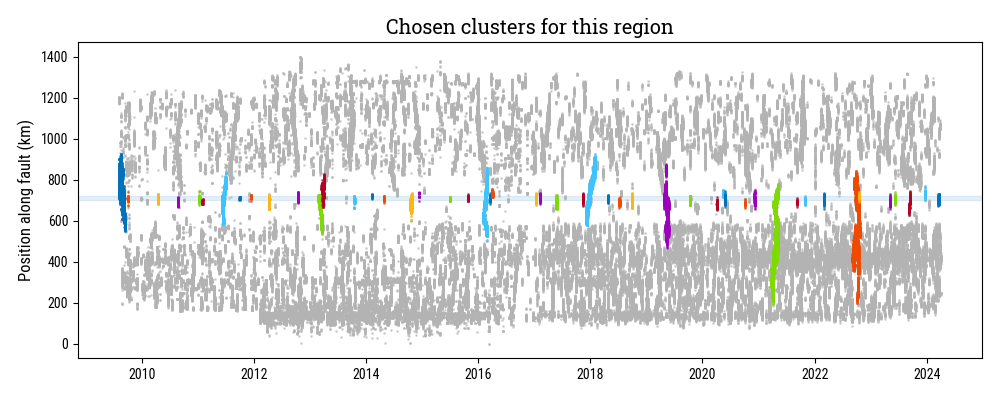

In [71]:
# Show
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Chosen clusters for this region', fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')

ax.axhspan(bin_xmin, bin_xmax, color='C0', alpha=.1)

ax.plot(tremor.date, tremor.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in selected_clusters.id:
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

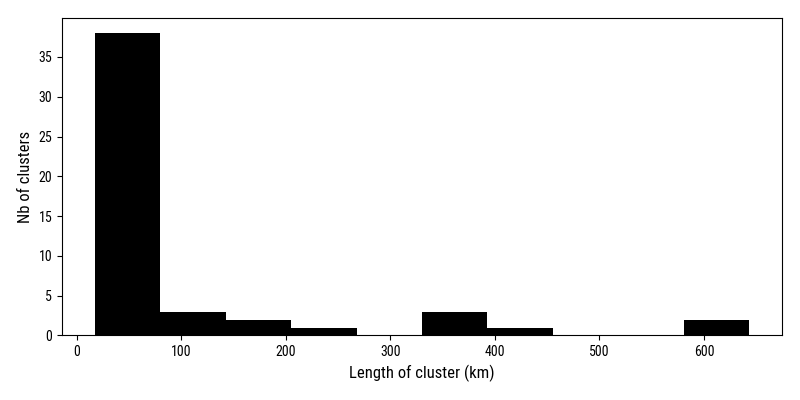

In [72]:
# Length distribution of the detected clusters
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(selected_clusters.x_max - selected_clusters.x_min, bins=10, color='k')
ax.set_ylabel('Nb of clusters')
ax.set_xlabel('Length of cluster (km)')
plt.tight_layout()
plt.show()

In [74]:
# Measures of synchronization
cov = np.std(selected_clusters.x_max - selected_clusters.x_min) / np.mean(selected_clusters.x_max - selected_clusters.x_min)
print('Coefficient of variation of cluster length: {:.2f}'.format(cov))

from scipy.stats import weibull_min
u_weibull = weibull_min.fit(selected_clusters.x_max - selected_clusters.x_min, floc=10)[0]
print('Weibull shape parameter for cluster length: {:.2f}'.format(u_weibull))

mean = np.mean(selected_clusters.x_max - selected_clusters.x_min)
print('mean length of cluster: {:.2f} km'.format(mean))

Coefficient of variation of cluster length: 1.23
Weibull shape parameter for cluster length: 0.93
mean length of cluster: 112.66 km


In [82]:
# Try them across the zone
# Parameters

wbin = 20  # in km, the width of the bin
xmin = 200  # in km, the northern limit of the binning
xmax = 1200  # in km, the southern limit of the binning

bin_xmins = np.arange(xmin, xmax - wbin, wbin)
bin_xmaxs = bin_xmins + wbin

# Initialize empty arrays to store the results
covs = np.zeros_like(bin_xmins).astype(float)
means = np.zeros_like(bin_xmins).astype(float)
medians = np.zeros_like(bin_xmins).astype(float)

for ii, (bin_xmin, bin_xmax) in enumerate(zip(bin_xmins, bin_xmaxs)):
    # Select clusters in bin
    fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
    xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
    xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

    cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

    selected_clusters = clusters_df[cluster_in_bin]

    # Compute different measures of synchronization
    cov = np.std(selected_clusters.x_max - selected_clusters.x_min) / np.mean(selected_clusters.x_max - selected_clusters.x_min)
    print(cov)
    covs[ii] = cov

    mean = np.mean(selected_clusters.x_max - selected_clusters.x_min)
    means[ii] = mean

    median = np.median(selected_clusters.x_max - selected_clusters.x_min)
    medians[ii] = median

0.7474765344582966
0.7285105902347927
0.7270496953607749
0.8056660265656126
0.9110068240281414
0.9152274881819726
0.8726054193179597
0.7614578892632458
0.7784428530285337
0.7667646149772912
0.779094719751996
0.7713508870857019
0.7741345820184302
0.7849342692089172
0.8150768867478575
0.9138078302020086
1.0558135202739953
1.0705847693729034
1.0809940037689056
1.1298203728311795
0.8093710118377778
0.960639497806848
1.102018520677641
1.1937788463500327
1.2334013975637736
1.2645809800860883
1.1616068669799438
1.0514986414542296
0.861302825340135
0.8277832522904004
0.9328184448199897
0.9670599357221686
1.047824497747041
0.94587726552314
0.9209939989105307
0.8989662881270919
0.9264830440967773
0.8926464445483984
0.8936829195015416
0.8716154303006826
0.8999077342153478
0.908830137135217
0.9059330199745258
0.8426764144458002
0.8681449112560741
0.9147596099698874
0.9152640584498176
0.9817331878102381
0.978921732099747


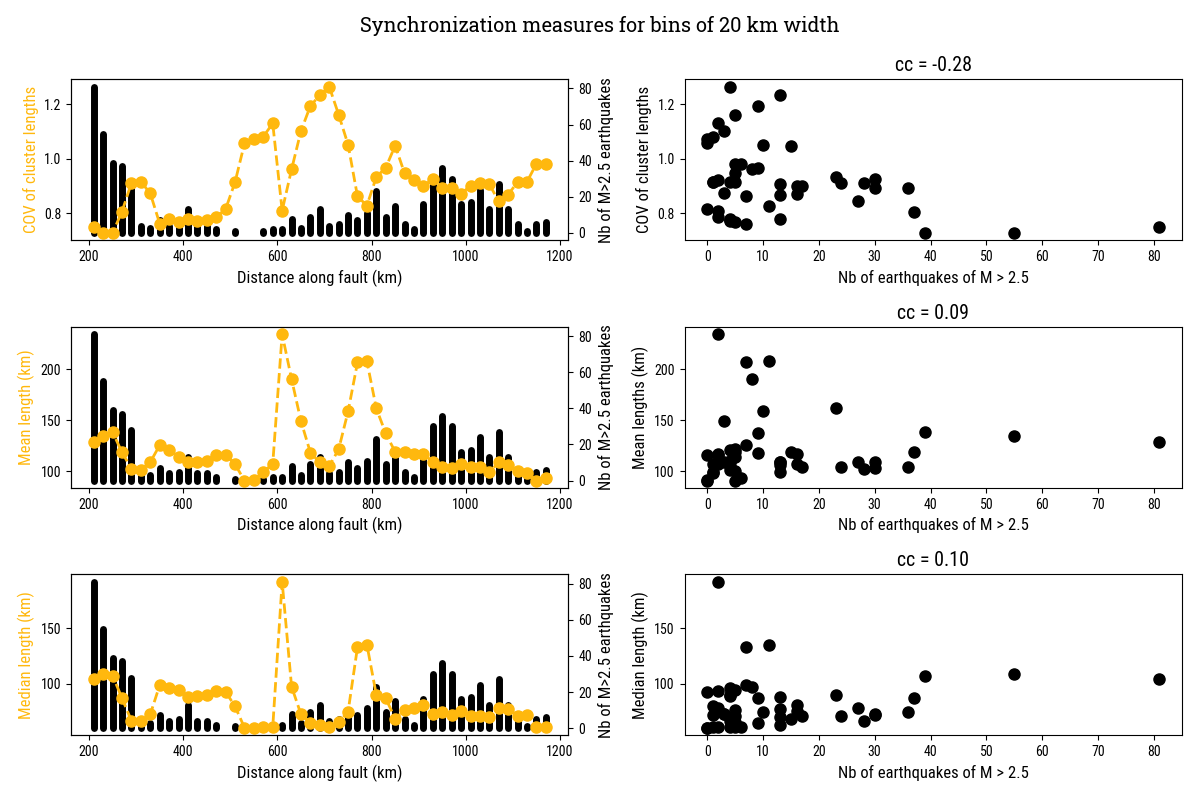

In [85]:
# Plot
mag_min = 2.5
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Synchronization measures for bins of {:} km width'.format(wbin), fontname='Roboto Slab')

axes[0, 0].plot(bin_xmins + wbin/2, covs, 'o--', c='C2', ms=8, lw=2)
axes[0, 0].set_ylabel('COV of cluster lengths', c='C2')
axes_1 = []
axes_1.append(axes[0, 0])

axes[1, 0].plot(bin_xmins + wbin/2, means, 'o--', c='C2', ms=8, lw=2)
axes[1, 0].set_ylabel('Mean length (km)', c='C2')
axes_1.append(axes[1, 0])

axes[2, 0].plot(bin_xmins + wbin/2, medians, 'o--', c='C2', ms=8, lw=2)
axes[2, 0].set_ylabel('Median length (km)', c='C2')
axes_1.append(axes[2, 0])

for ax in axes_1:
    ax_eq = ax.twinx()
    # count earthquakes in each bin
    eq_in_bin = np.array([len(eq_near[(eq_near.xf >= bin_xmin - 10) & (eq_near.xf <= bin_xmax - 10) & (eq_near.mag > mag_min)]) for bin_xmin, bin_xmax in zip(bin_xmins, bin_xmaxs)])
    X, Y = [], []
    for x,y in zip(bin_xmins + wbin/2, eq_in_bin):
        X.extend([x, x, None]), Y.extend([0, y, None])
    ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
    ax.set_zorder(ax_eq.get_zorder()+1)
    ax.patch.set_visible(False)
    ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

    ax.set_xlabel('Distance along fault (km)')


axes[0, 1].plot(eq_in_bin, covs, 'o', c='k', ms=8, lw=2)
axes[0, 1].set_ylabel('COV of cluster lengths', c='k')
axes[0, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[0, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, covs)[0, 1]))

axes[1, 1].plot(eq_in_bin, means, 'o', c='k', ms=8, lw=2)
axes[1, 1].set_ylabel('Mean lengths (km)', c='k')
axes[1, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[1, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, means)[0, 1]))

axes[2, 1].plot(eq_in_bin, medians, 'o', c='k', ms=8, lw=2)
axes[2, 1].set_ylabel('Median length (km)', c='k')
axes[2, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[2, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, medians)[0, 1]))

plt.tight_layout()
plt.show()